In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
furl = "../data/GHS_BUILT_S_E2018_GLOBE_R2023A_54009_10_V1_0_R4_C20.tif"

In [3]:
import rioxarray
bus = rioxarray.open_rasterio(furl).squeeze()

In [4]:
bus

<xarray.DataArray (y: 100000, x: 100000)> Size: 10GB
[10000000000 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 800kB 9.59e+05 9.59e+05 ... 1.959e+06 1.959e+06
  * y            (y) float64 800kB 6e+06 6e+06 6e+06 6e+06 ... 5e+06 5e+06 5e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [6]:
region_id = 69333

In [7]:
etcs = morphotopes_to_etcs(region_id)

In [8]:
# etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/enclosures/enclosure_{region_id}.parquet')

In [9]:
etcs['num_index'] = np.arange(1, etcs.shape[0] + 1)

In [10]:
etcs_utm = etcs.to_crs(bus.rio.crs)

In [11]:
geom = etcs_utm.reset_index()[['geometry', 'num_index']].values.tolist()

In [12]:
import shapely

In [13]:
shapely.GeometryCollection(etcs_utm.geometry.values).bounds

(1056322.2981511406, 5824057.637521706, 1175687.5972397642, 5913205.059116768)

In [14]:
minx, miny, maxx, maxy = shapely.GeometryCollection(etcs_utm.geometry.values).bounds

In [15]:
test = rioxarray.open_rasterio(
    filename=furl, 
    chunks='auto', 
    parse_coordinates=False,
    masked=True
).rio.clip_box(minx, miny, maxx, maxy)

In [16]:
# geom2 = [[g,i] for g, i in geom if i == shp_id]

In [18]:
from rasterio import features
fields_rasterized = features.rasterize(geom, out_shape=(test.shape[1], test.shape[2]), transform=test.rio.transform())

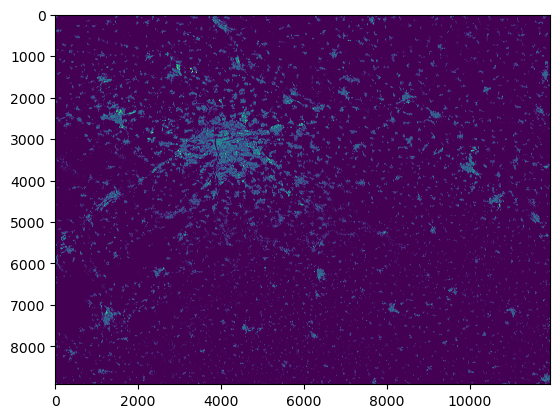

In [19]:
import matplotlib.pyplot as plt
plt.imshow(test.data[0])

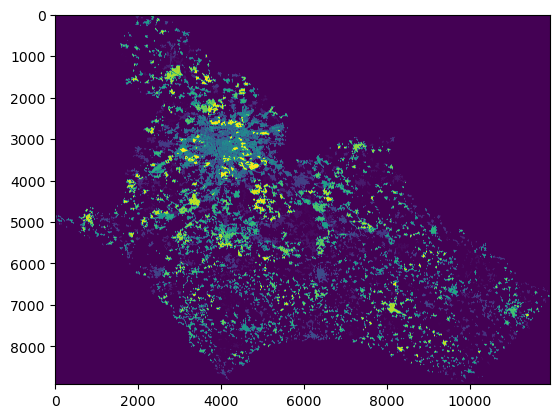

In [20]:
plt.imshow(fields_rasterized)

In [21]:
import shapely
from rasterio import transform

In [22]:
# vector_shapes = []


# for i, r in enumerate(shapes):
#     if i > 10:
#         break
#     i += 1

#     idxs = np.array(r[0]['coordinates'][0], dtype=np.int32)


#     xs, ys = transformer.xy(idxs[:, 1], idxs[:, 0], offset='ul')
#     coords = np.vstack((xs, ys)).T
#     shp = shapely.Polygon(coords)

#     unique_idxs = np.unique(idxs, axis=0)
#     bu_sum = test[0, unique_idxs[:, 1], unique_idxs[:, 0]].sum().values

    
#     # with transform set
#     # shp = shapely.Polygon(np.array(r[0]['coordinates'][0])[:, [0,1]])


#     shp_id = r[1]
#     vector_shapes.append([shp, shp_id, bu_sum])

In [23]:
# gdf = gpd.GeoDataFrame(vector_shapes, columns = ['geometry', 'id', 'bu_sum'], crs = test.rio.crs)
# gdf = gdf.merge(etcs.reset_index()[['index', 'num_index']], left_on='id', right_on='num_index')

# m = etcs.loc[gdf['index'].values].explore(color='red')
# m = gdf.explore(m=m)
# m

In [24]:
ebua = pd.Series(test.as_numpy().values.flatten()).groupby(fields_rasterized.flatten()).agg(['sum', 'describe'])
ebua.columns = ebua.columns.get_level_values(1)
ebua.columns = ['sum'] + ebua.columns[1:].tolist()

In [25]:
etcs = etcs.merge(ebua, left_on='num_index', right_index=True, how='left')

In [26]:
etcs = etcs.fillna(0)

In [27]:
etcs['ratio'] = etcs['sum'] / etcs.area
etcs['area'] = etcs.area

In [28]:
(etcs['sum'] > etcs['area']).sum()

np.int64(2321)

In [29]:
buildings = morphotopes_to_etcs(region_id, etcs=False)

In [30]:
buildings.area

0         137.301434
1         130.923970
2          91.956941
3          69.749808
4          95.799867
             ...    
447721    330.159160
447722    495.880998
447723    210.397859
447724    595.663481
447725    301.924754
Length: 447726, dtype: float64

In [73]:
etcs['barea'] = buildings.area
etcs['barea'] = etcs['barea'].fillna(0)

etcs['bperi'] = buildings.length
etcs['bperi'] = etcs['bperi'].fillna(0)

In [74]:
lrg = (etcs['sum'] < etcs['barea']) & (etcs.index >= 0)

In [75]:
### total builtup surface should be atleast the etcs building area
etcs.loc[lrg, 'sum'] = etcs.loc[lrg, 'barea']

In [34]:
etcs['nbs'] = etcs['sum'] - etcs['barea']

In [35]:
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'
from libpysal.graph import read_parquet

In [36]:
graph = read_parquet(graph_dir + f'tessellation_graph_{region_id}.parquet')

In [37]:
graph3 = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [38]:
##sums
etcs['nbs3'] = graph3.lag(etcs['nbs'].values)
etcs['ratio3'] = graph3.lag(etcs['ratio'].values)

In [39]:
## means
graph3.transform = 'R'
etcs['nbs3_m'] = graph3.lag(etcs['nbs'].values)
etcs['ratio3_m'] = graph3.lag(etcs['ratio'].values)

In [110]:
res = mm.centroid_corner_distance(buildings)

/home/krasen/urban_taxonomy/manual_deps/momepy/momepy/functional/_shape.py:737: RuntimeWarning: Mean of empty slice
  return Series({"mean": np.nanmean(dists), "std": np.nanstd(dists)})
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krasen/urban_taxonomy/manual_deps/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


In [115]:
## doesnt really add much. mean is basically area
etcs['cor_std'] = res['std']
etcs['cor_mean'] = res['mean']

etcs['cor_std'] = etcs['cor_std'].fillna(0)
etcs['cor_mean'] = etcs['cor_mean'].fillna(0)

res = graph.describe(etcs['cor_std'])
etcs['cor_std'] = res['mean']

res = graph.describe(etcs['cor_mean'])
etcs['cor_mean'] = res['std']

In [139]:
## nothing much
etcs['sicar'] = etcs['barea'] / etcs['area']
res = graph.describe(etcs['sicar'])
etcs['sicar_std'] = res['mean']

In [58]:
res = graph.describe(etcs['barea'])
etcs['barea_std'] = res['std']

In [82]:
res = graph.describe(etcs['bperi'])
etcs['bperi_std'] = res['std']

In [90]:
import momepy as mm

In [91]:
etcs['fr'] = mm.facade_ratio(etcs)

In [92]:
res = graph.describe(etcs['fr'])
etcs['fr_std'] = res['std']

In [100]:
# res = graph3.describe(etcs['barea'])
# etcs['barea_lstd'] = res['std']

In [50]:
etcs['75%_m'] = graph3.lag(etcs['75%'].values)

In [40]:
etcs['bratio'] = etcs['sum'] / etcs['barea']

In [140]:
plotting = etcs[etcs.index >= 0]

In [117]:
import lonboard
from sidecar import Sidecar

In [119]:
# layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

In [69]:
sc = Sidecar(title='tess')
m = lonboard.Map(layer)
with sc:
    display(m)

In [70]:
etcs.columns

Index(['enclosure_index', 'geometry', 'label', 'morph', 'num_index', 'sum',
       'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'ratio',
       'area', 'barea', 'nbs', 'nbs3', 'ratio3', 'nbs3_m', 'ratio3_m',
       'bratio', '75%_m', 'barea_std'],
      dtype='object')

In [141]:
column = 'sicar_std'

In [142]:
from lonboard.colormap import apply_continuous_cmap
import matplotlib as mpl
from mapclassify import classify

classifier = classify(plotting[column], 'quantiles', k=100)
normalizer = mpl.colors.Normalize(0, classifier.bins.shape[0])
vals = normalizer(classifier.yb)
layer.get_fill_color = apply_continuous_cmap(vals, mpl.colormaps['viridis'])

In [ ]:
### ratio of larger buildings around ???


### 2 things - 75% builtup area... maybe lag it, plus differences in neighbour areas, now leghts and maybe squareness...

In [68]:
res = etcs.dissolve('morph', aggfunc=['mean', 'sum'])

In [76]:
res.columns

Index([                 'geometry', ('enclosure_index', 'mean'),
        ('enclosure_index', 'sum'),           ('label', 'mean'),
                  ('label', 'sum'),       ('num_index', 'mean'),
              ('num_index', 'sum'),            ('mean', 'mean'),
                   ('mean', 'sum'),          ('median', 'mean'),
                 ('median', 'sum'),             ('sum', 'mean'),
                    ('sum', 'sum'),           ('ratio', 'mean'),
                  ('ratio', 'sum'),            ('area', 'mean'),
                   ('area', 'sum')],
      dtype='object')

In [79]:
res = res[~(res.index.str.split('_').str[-1] == '-1')]

In [91]:
res.columns = res.columns.str.join('_')
res.columns = ['geometry'] + list(res.columns[1:]) 

In [106]:
res['morph_ratio'] = res['sum_sum'] / res.area

In [110]:
# res.reset_index().explore(prefer_canvas=True, tiles='cartodb.Positron', column=res['morph_ratio'].values)

In [122]:
# spatial lag the values ...
# try sum of construction minus building area  ...
# ratio of construction to building